In [1]:
# Vi ønsker at finde the efficient frontier med faktiske data. I princippet burde vi bruge alle mulige 
# finansielle aktiver, men vi starter med Apple, Microsoft, Amazon, Google og META (Facebook). 
# Vi bruger yfinance til at hente data fra dette århundrede 

In [2]:
# -----------------------------------------------------------------------
# Data download & monthly-return table  (yfinance ≥ 0.2.59 compatible)
# -----------------------------------------------------------------------
import warnings
import pandas as pd
import numpy as np
import yfinance as yf

# 0️⃣  (optional) hide the auto_adjust banner – wording is stable across versions
warnings.filterwarnings(
    "ignore",
    message=".*auto_adjust default has changed.*",
    category=UserWarning,
    module="yfinance"
)

# 1️⃣  tickers and download
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META']
data = yf.download(
    tickers,
    start='2000-01-01',
    end='2023-05-01'        # inclusive of 2023-04-30
    # auto_adjust=True is the default in recent releases
)

# 2️⃣  fully adjusted prices are now in the “Close” field
data = data['Close']            # drop the first-level column “Close”

# 3️⃣  daily  ➜  month-end prices  ➜  pct-change returns
data_monthly    = data.resample('M').ffill()
returns_monthly = data_monthly.pct_change().dropna()

# 4️⃣  stats every later cell expects
average_returns = returns_monthly.mean()      # Series (μ)
cov_matrix      = returns_monthly.cov()       # DataFrame (Σ)

print("Prepared monthly return table with shape:", returns_monthly.shape)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed

Prepared monthly return table with shape: (131, 5)



C:\Users\graug\AppData\Local\Temp\ipykernel_13816\3692054644.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly    = data.resample('M').ffill()


In [3]:
# Vi laver en portefolio der har  lige vægt i alle aktierne. 
# Vi simulerer 1000 draws fra fordelingen. Vi antager at middelværdi og covariance er som estimteret foroven
# Vi antager normalfordelte afkast.

In [4]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Define the weights for the portfolio (equal weights)
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Run 1000 simulations
num_simulations = 1000
simulated_returns = []
for i in range(num_simulations):
    # Draw returns for the five companies
    drawn_returns = np.random.multivariate_normal(average_returns, cov_matrix)
    # Calculate the portfolio return
    portfolio_return = np.sum(drawn_returns * weights)
    simulated_returns.append(portfolio_return)

# Convert the list to a numpy array
simulated_returns = np.array(simulated_returns)

# Calculate the mean and standard deviation
mean_simulation = np.mean(simulated_returns)
std_simulation = np.std(simulated_returns)

print(f"Mean of the simulated returns: {mean_simulation}")
print(f"Standard deviation of the simulated returns: {std_simulation}")


Mean of the simulated returns: 0.020551458333708587
Standard deviation of the simulated returns: 0.06092182691491748


In [5]:
# Vi plotter denne portefølje i et plot med varians og standardafvigelse sammen med hver af de 5 individuelle aktier. 

C:\Users\graug\AppData\Local\Temp\ipykernel_13816\1665195081.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (individual_stds[i], individual_means[i]))


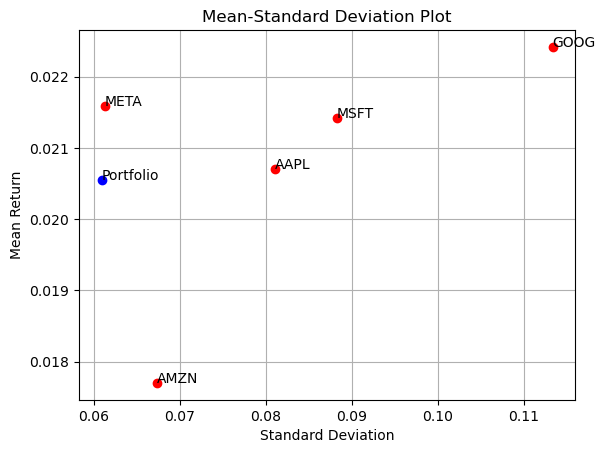

In [6]:
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation of each stock
individual_means = average_returns
individual_stds = returns_monthly.std()

# Plot individual stocks
plt.scatter(individual_stds, individual_means, color='red')
for i, txt in enumerate(tickers):
    plt.annotate(txt, (individual_stds[i], individual_means[i]))

# Plot the result of the simulation
plt.scatter(std_simulation, mean_simulation, color='blue')
plt.annotate("Portfolio", (std_simulation, mean_simulation))

# Set the labels for the axes
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Return')

# Set the title of the plot
plt.title('Mean-Standard Deviation Plot')

# Show the plot
plt.grid(True)
plt.show()


In [7]:
# Men der er ingen garanti for at det er det bedste vi kan gøre! Vi kunne regne det ud, men vi tager bare 1000 
# tilfældige porteføljer og plotter dem tilsvarende som figuren foroven. Vi kan visuelt se hvad den efficient frontier 
# er. Vi tilføjer linien mellem det risikofri aktiv og the efficient frontier. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of portfolios to simulate
num_portfolios = 500

# Number of simulations for each portfolio
num_simulations = 1000000

# Create empty arrays to store the results
portfolio_means = np.zeros(num_portfolios)
portfolio_stds = np.zeros(num_portfolios)
sharpe_ratios = np.zeros(num_portfolios)  # Store Sharpe Ratios here

# Store the weights of each portfolio
portfolio_weights = np.zeros((num_portfolios, len(tickers)))

r_f = 0.01  # risk-free rate

np.random.seed(42) # for reproducibility

# Perform the simulations
for i in range(num_portfolios):
    # Generate random weights that sum up to 1
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Store weights
    portfolio_weights[i, :] = weights

    # Perform the simulation
    returns_simulation = np.random.multivariate_normal(average_returns, cov_matrix, num_simulations) @ weights

    # Calculate the mean and standard deviation
    portfolio_means[i] = np.mean(returns_simulation)
    portfolio_stds[i] = np.std(returns_simulation)
    
    # Calculate Sharpe Ratio
    sharpe_ratios[i] = (portfolio_means[i] - r_f) / portfolio_stds[i]

# Get the portfolio with the maximum Sharpe Ratio
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_std = portfolio_stds[max_sharpe_idx]
max_sharpe_mean = portfolio_means[max_sharpe_idx]

# Get the weights of the portfolio with the maximum Sharpe Ratio
max_sharpe_weights = portfolio_weights[max_sharpe_idx, :]

# Plot individual stocks
plt.scatter(individual_stds, individual_means, color='red', label='Individual Stocks')
for i, txt in enumerate(tickers):
    plt.annotate(txt, (individual_stds[i], individual_means[i]))

# Plot the portfolios
plt.scatter(portfolio_stds, portfolio_means, color='blue', alpha=0.5, label='Portfolios')

# Highlight the portfolio with maximum Sharpe Ratio
plt.scatter(max_sharpe_std, max_sharpe_mean, color='yellow', label='Max Sharpe Ratio')

# Draw a line between the risk-free rate and the portfolio with the maximum Sharpe Ratio
plt.plot([0, max_sharpe_std, max_sharpe_std + 0.01], [r_f, max_sharpe_mean, r_f + (max_sharpe_std + 0.01 - 0) * ((max_sharpe_mean - r_f) / (max_sharpe_std - 0))], color='orange')

# Set the labels for the axes
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Return')

# Set the x-axis to start from 0
plt.xlim([0, max(portfolio_stds.max(), individual_stds.max()) + 0.01])  # 0.01 is added to extend the x-axis

# Set the title of the plot
plt.title('Mean-Standard Deviation Plot')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Display the weights of the portfolio with the maximum Sharpe Ratio
print(f"Weights of the portfolio with maximum Sharpe ratio tickers [AAPL,MSFT,AMZN,GOOG,META]: {[round(w, 2) for w in max_sharpe_weights]}")
